### DiffuseVAE Formulation 1 (128 x 128) CelebA

In [13]:
# prompt: mount to google drive

from google.colab import drive
drive.mount('/content/drive')


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

import kagglehub
from torch.utils.data import DataLoader, Subset
from pathlib import Path
from PIL import Image
from torchvision.datasets import ImageFolder

import torchvision.utils as vutils
from diffusers import UNet2DModel, DDPMScheduler
import numpy as np

import torch.nn.functional as F


In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters for VAE
IMG_SIZE = 128
LATENT_DIM = 128
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
EPOCHS = 50

In [3]:
# Preparing the dataset

# Download dataset using kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
data_dir = Path(path) / "img_align_celeba"

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
])

# Load CelebA dataset from KaggleHub
dataset = ImageFolder(root=str(data_dir.parent), transform=transform)

# Select random 80k images from first 162770 images
torch.manual_seed(42)
indices = torch.randperm(162770)[:80000]
train_dataset = Subset(dataset, indices.tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [8]:
# Define VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(128, 256, 4, 2, 1), nn.ReLU()
        )
        self.fc_mu = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(256 * 8 * 8, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 256 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1), nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def encode(self, x):
        x = self.encoder(x).view(x.size(0), -1)
        mu, logvar = self.fc_mu(x), self.fc_logvar(x)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def decode(self, z):
        x = self.fc_decode(z).view(z.size(0), 256, 8, 8)
        return self.decoder(x)

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

# Loss function
def loss_function(recon_x, x, mu, logvar):
    recon_loss = nn.functional.mse_loss(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [10]:
TRAIN_VAE = False # set to true for new model

In [11]:
# Train the model
vae = VAE(LATENT_DIM).to(device)

if not TRAIN_VAE:
  # Load pretrained model
  PATH = "/content/vae_model_celeba_50_convention_gpt.pth"
  vae.load_state_dict(torch.load(PATH))
  print(f"VAE model at {PATH} loaded successfully!")
else:
  optimizer = optim.Adam(vae.parameters(), lr=LEARNING_RATE)

  for epoch in range(EPOCHS):
      vae.train()
      train_loss = 0
      for imgs, _ in train_loader:
          imgs = imgs.to(device)
          optimizer.zero_grad()
          recon_imgs, mu, logvar = vae(imgs)
          loss = loss_function(recon_imgs, imgs, mu, logvar)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {train_loss/len(dataset):.4f}")

  # Save the trained model
  torch.save(vae.state_dict(), "/content/vae_model_celeba_50_2.pth")

  print("Training complete!")

VAE model at /content/vae_model_celeba_50_convention_gpt.pth loaded successfully!


In [7]:
# Display some reconstructions
def show_reconstructions(loader, title):
    vae.eval()
    with torch.no_grad():
        imgs, _ = next(iter(loader))
        imgs = imgs.to(device)
        recon_imgs, _, _ = vae(imgs)
        imgs, recon_imgs = imgs.cpu(), recon_imgs.cpu()
        fig, axes = plt.subplots(2, 8, figsize=(12, 4))
        for i in range(8):
            axes[0, i].imshow(imgs[i].permute(1, 2, 0))
            axes[0, i].axis('off')
            axes[1, i].imshow(recon_imgs[i].permute(1, 2, 0))
            axes[1, i].axis('off')
        plt.suptitle(title)
        plt.show()
    return recon_imgs

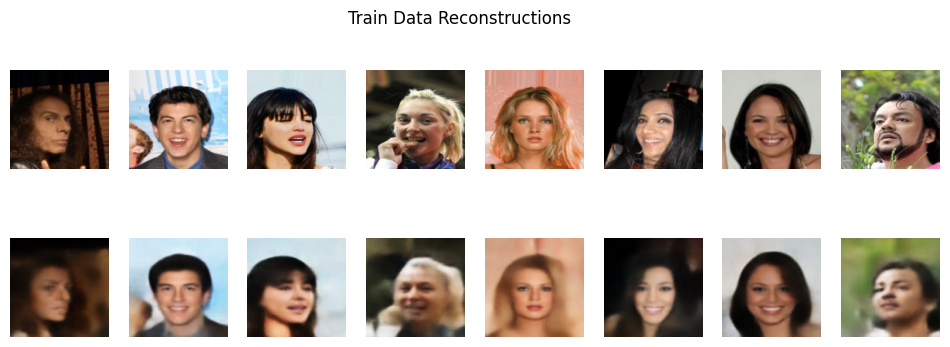

In [8]:
recon_imgs = show_reconstructions(train_loader, "Train Data Reconstructions")

In [3]:
BATCH_SIZE = 16
EPOCHS = 50
LR = 2e-4
TOTAL_TIMESTEPS=1000

In [4]:
# Preparing the dataset

# Download dataset using kagglehub
path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
data_dir = Path(path) / "img_align_celeba"

# Dataset transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128
    transforms.ToTensor(),
])

# Load CelebA dataset from KaggleHub
dataset = ImageFolder(root=str(data_dir.parent), transform=transform)

# Select random 80k images from first 162770 images
torch.manual_seed(42)
indices = torch.randperm(162770)[:80000]
train_dataset = Subset(dataset, indices.tolist())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [3]:
# Data Loading and Preprocessing
# transform = transforms.Compose([
#     transforms.CenterCrop(178),  # Crop center to remove background
#     transforms.Resize((IMG_SIZE, IMG_SIZE)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5], [0.5])
# ])
# import kagglehub
# path = kagglehub.dataset_download("jessicali9530/celeba-dataset")
# torch.manual_seed(42)
# indices = torch.randperm(162770)[:80000] # 80k subset of training image indices
# indices = torch.randperm(162770)[:10000] # 80k subset of training image indices

# dataset = datasets.ImageFolder(root=path, transform=transform)
# dataset = Subset(dataset, indices)  # Create subset of dataset

# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

In [11]:
# Define the UNet model

# Define your diffusion U-Net model (accepting 6-channel input: x_t + x̂₀)
diffusion_model = UNet2DModel(
    sample_size=128,
    in_channels=6,  # <-- because we concat x_t (3 channels) and x̂₀ (3 channels)
    out_channels=3,
    layers_per_block=2,
    block_out_channels=[64, 128, 256, 512, 512],
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "DownBlock2D", "AttnDownBlock2D", "DownBlock2D"),
    up_block_types=("UpBlock2D", "AttnUpBlock2D", "UpBlock2D", "AttnUpBlock2D", "UpBlock2D")
).to(device)

# Diffusion scheduler (Using cosine beta schedule)
betas = np.linspace(1e-5, 1e-2, TOTAL_TIMESTEPS, dtype=np.float32)

scheduler = DDPMScheduler(
    num_train_timesteps=TOTAL_TIMESTEPS,
    trained_betas=torch.tensor(betas, dtype=torch.float32, device=device)
)

# Optimizer with Cosine Annealing LR Scheduler
optimizer = optim.AdamW(diffusion_model.parameters(), lr=LR, betas=(0.9, 0.999), weight_decay=1e-2)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

/usr/local/lib/python3.11/dist-packages/diffusers/schedulers/scheduling_ddpm.py:200: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.betas = torch.tensor(trained_betas, dtype=torch.float32)


In [6]:
def train_ddpm_step(vae, diffusion_model, scheduler, optimizer, real_images):
    diffusion_model.train()
    optimizer.zero_grad()

    # Get VAE reconstruction
    with torch.no_grad():
        z,mu,logvar = vae.encode(real_images)
        x_hat_0 = vae.decode(z)               # shape: (B, 3, 128, 128)

    # Sample random timestep t
    bsz = real_images.size(0)
    t = torch.randint(0, scheduler.num_train_timesteps, (bsz,), device=real_images.device).long()

    # Sample noise and create x_t
    noise = torch.randn_like(real_images)
    x_t = scheduler.add_noise(real_images, noise, t)

    # Concatenate x_t and x̂₀
    model_input = torch.cat([x_t, x_hat_0], dim=1)  # shape: (B, 6, 128, 128)

    # Predict noise
    pred_noise = diffusion_model(model_input, timestep=t).sample

    # Loss (mean squared error between predicted noise and true noise)
    loss = nn.MSELoss()(pred_noise, noise)
    loss.backward()
    optimizer.step()

    return loss.item()

In [9]:
# === 6. Assume you have a pretrained VAE ===
# Must implement: encode(x) and decode(z)
vae = VAE(LATENT_DIM).to(device)

# Load pretrained model
vae.load_state_dict(torch.load("/content/vae_model_celeba_50_convention_gpt.pth"))
vae.eval()  # Freeze VAE
for p in vae.parameters():
    p.requires_grad = False


In [12]:
for epoch in range(EPOCHS):
    total_loss = 0
    for i, (images, _) in enumerate(train_loader):
        images = images.to(device)

        loss = train_ddpm_step(vae, diffusion_model, scheduler, optimizer, images)
        total_loss += loss

        if i % 100 == 0:
            print(f"Epoch {epoch+1} | Step {i} | Loss: {loss:.4f}")

            torch.save(diffusion_model.state_dict(), f"/content/drive/MyDrive/diffusion_celeba_epoch{epoch}_{i}.pth")


    # Every epoch save checkpoint
    torch.save(diffusion_model.state_dict(), f"/content/drive/MyDrive/diffusion_celeba_epoch{epoch}.pth")

    lr_scheduler.step()
    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} completed. Avg Loss: {avg_loss:.4f}")


/usr/local/lib/python3.11/dist-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 1 | Step 0 | Loss: 1.0686


KeyboardInterrupt: 

In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def show_images(images, title=""):
    images = (images.clamp(-1, 1) + 1) / 2  # Normalize to [0, 1]
    grid = make_grid(images, nrow=5)
    npimg = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 5))
    plt.title(title)
    plt.imshow(npimg)
    plt.axis("off")
    plt.show()


In [ ]:
def sample_from_diffuse_vae(vae, diffusion_model, scheduler, num_samples=10):
    diffusion_model.eval()
    vae.eval()

    with torch.no_grad():
        # Sample z from standard normal
        z = torch.randn((num_samples, vae.latent_dim)).to(device)

        # Decode to get x̂₀ from VAE
        x_hat_0 = vae.decode(z)

        # Start from pure noise
        x_t = torch.randn_like(x_hat_0)

        for t in reversed(range(scheduler.num_train_timesteps)):
            t_batch = torch.tensor([t] * num_samples, device=device)

            # Prepare model input: [x_t || x̂₀]
            model_input = torch.cat([x_t, x_hat_0], dim=1)

            # Predict noise
            with torch.no_grad():
                noise_pred = diffusion_model(model_input, timestep=t_batch).sample

            # DDPM reverse step
            x_t = scheduler.step(noise_pred, t_batch, x_t).prev_sample

        return x_t

def reconstruct_with_diffuse_vae(vae, diffusion_model, scheduler, real_images, num_samples=10):
    diffusion_model.eval()
    vae.eval()

    images = real_images[:num_samples].to(device)

    with torch.no_grad():
        z = vae.encode(images).sample()
        x_hat_0 = vae.decode(z)

        # Start from noise
        x_t = torch.randn_like(x_hat_0)

        for t in reversed(range(scheduler.num_train_timesteps)):
            t_batch = torch.tensor([t] * num_samples, device=device)
            model_input = torch.cat([x_t, x_hat_0], dim=1)
            noise_pred = diffusion_model(model_input, timestep=t_batch).sample
            x_t = scheduler.step(noise_pred, t_batch, x_t).prev_sample

        return x_t, images  # Return both reconstructed and original


In [ ]:
# 1. Generate 10 samples from scratch
samples = sample_from_diffuse_vae(vae, diffusion_model, scheduler, num_samples=10)
show_images(samples, title="Generated Samples")

# 2. Reconstruct 10 real images
real_batch = next(iter(train_loader))[0]
recon, originals = reconstruct_with_diffuse_vae(vae, diffusion_model, scheduler, real_batch, num_samples=10)

show_images(originals, title="Originals")
show_images(recon, title="Reconstructed via VAE + DDPM")
